# Imports

In [1]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import imageio
from io import BytesIO

# Global variables

In [2]:
WIDTH = 120
HEIGHT = 120
OS = "linux"
valid_size = 0.2
label_name = ["palm_horizontal", "L", "fist_horizontal", "fist_vertical", "thumb_up", "index", "ok", "palm_vertical", "C", "thumb_down"]

# Loading data

In [5]:
def load_labelling_data(width, height, oper_sys):
    X = []
    y = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if path.split(split_)[-1][0].isalpha():
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (width, height))
                    X.append(img)
                    # Loading labels
                    category = path.split(split_)[-1].split("_")[0]
                    # label = int(category.split("_")[0]) - 1
                    y.append(category)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

def load_test_data(width, height, oper_sys):
    X = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if not path.split(split_)[-1][0].isalpha() and path.split(split_)[-1][0] != ".":
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (width, height))
                    X.append(img)
    X = np.array(X)
    return X.reshape(X.shape[0], height, width, 1)

def load_dataset_data(width, height, oper_sys):
    X = []
    y = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, dirs, files in tqdm(os.walk(".", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("png"):
                # Loading labels
                category = path.split(split_)[4]
                label = int(category.split("_")[0]) - 1
                y.append(label)
                # Loading images
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (width, height))
                X.append(img)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

def get_background_images():
	images = []
	with open('data_background/test.mkv', 'rb') as file: # kaggle : ../input/hand-gesture/data_background/test.mkv
		content = file.read()
	vid = imageio.get_reader(BytesIO(content),  'ffmpeg')
	images = []
	for num, image in enumerate(vid.iter_data()): 
		if num % 14 == 0:
			img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis]
			images.append(img)
	return np.array(images)

In [6]:
X_labelling, y_labelling = load_labelling_data(WIDTH, HEIGHT, OS)
background_images = get_background_images()

125it [00:00, 1220.13it/s]


In [7]:
print(X_labelling.shape)
print(y_labelling.shape)
print(background_images.shape)

(99, 120, 120, 1)
(99,)
(104, 720, 960, 1)


# Data augmentation

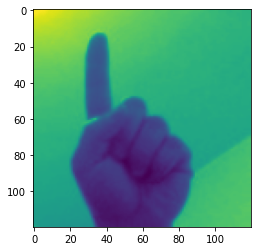

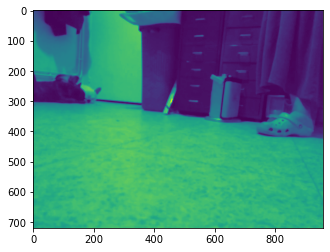

In [8]:
plt.imshow(X_labelling[0])
plt.show()
plt.imshow(background_images[0])
plt.show()

In [9]:
def add_background_to_data(background_images, hand_images, labels):
    final_images = []
    new_labels = []
    for idx, hand_img in enumerate(tqdm(hand_images)):
        for background_img in background_images:
            for r in range(1, 4):
                resize = int(hand_img.shape[0]*r)
                hand_img_resized = cv2.resize(hand_img, (resize, resize))[:,:,np.newaxis]
                y_offset = np.random.randint(background_img.shape[0] - hand_img_resized.shape[0])
                x_offset = np.random.randint(background_img.shape[1] - hand_img_resized.shape[1])
                tmp = background_img.copy()
                tmp[y_offset:y_offset+hand_img_resized.shape[0], x_offset:x_offset+hand_img_resized.shape[1]] = hand_img_resized
                tmp = cv2.resize(tmp, (128, 128))[:,:,np.newaxis]
                final_images.append(tmp)
                new_labels.append(labels[idx])
    return np.array(final_images), np.array(new_labels)

In [10]:
X, y = add_background_to_data(background_images, X_labelling, y_labelling)
print(X.shape)
print(y.shape)

100%|██████████| 99/99 [00:09<00:00, 10.81it/s]


(30888, 128, 128, 1)
(30888,)


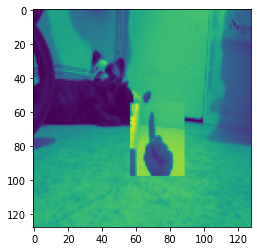

In [11]:
plt.imshow(X[1000])

In [12]:
label_names, y = np.unique(y, return_inverse=True) ## Converts to categorical int
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=42)

In [13]:
X_train.shape

(24710, 128, 128, 1)

# Building model

In [14]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(X_train[0].shape))) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_name), activation='softmax'))
    return model

# Training model

In [15]:
train_ = False

if train_ :
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=5, validation_data=(X_valid, y_valid))
    model.save('tmp_model.h5')
else:
    model = tf.keras.models.load_model("best_model.h5", custom_objects=None, compile=True, options=None)

model.summary()
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
print('Valid accuracy: {:2.2f}%'.format(valid_acc*100))

2022-04-03 18:19:24.441209: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-03 18:19:24.442728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-03 18:19:24.446336: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

2022-04-03 18:19:24.832051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-03 18:19:24.836637: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592000000 Hz


194/194 [==============================] - 12s 57ms/step - loss: 0.0154 - accuracy: 0.9947
Valid accuracy: 99.47%


# Inference

In [17]:
if train_:
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()

In [18]:
X_test = load_test_data(128, 128, "linux")

125it [00:01, 122.17it/s]


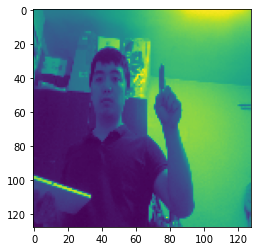

In [19]:
plt.imshow(X_test[0])

In [20]:
preds = np.argmax(model.predict(X_test), axis=1)
label_names

array(['FINGER', 'FIST', 'LEFT', 'PALM', 'RIGHT'], dtype='<U6')

In [22]:
# for i in range(len(preds)):
#     print("=======================================")
#     plt.imshow(X_test[i])
#     plt.show()
#     print(label_names[preds[i]])

In [24]:
inference_ = True

if inference_ :
    cv2.destroyAllWindows()

    before = time.time()
    vid = cv2.VideoCapture(0)
    while True:
        ret, frame = vid.read()
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # after = int(time.time() - before)
        # if after % 5 == 0:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        img = img.reshape(1, 128, 128, 1)
        print(label_name[np.argmax(model.predict(img))])

    vid.release()
    cv2.destroyAllWindows()

[ WARN:0] global ../modules/videoio/src/cap_v4l.cpp (893) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


error: OpenCV(4.5.1) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
